In [4]:
%load_ext autoreload
%autoreload 2

import os, pickle, random, sbmtm
import seaborn as sns; sns.set(style="white", color_codes=True) # is not installed on system, just folder in this directory
import numpy as np
import pandas as pd
from sbmtm import sbmtm
import matplotlib.pyplot as plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
TO DO: 
    - LOOK AT FREQUENCY CALCULATIONS
    - MAKE SURE THE DOCS ARE IN THE RIGHT ORDER
    - topic typology?

In [2]:
finished_books = [] # in case something breaks, we can pick up where we were

# calculates bin counts for binning documents through time
def calc_bin_sizes(count_docs, num_bins):
    min_split_count = int(count_docs/num_bins)
    extras = count_docs- min_split_count*num_bins

    counts = [min_split_count for i in range(num_bins)]
    for indx in random.sample(range(num_bins),extras):
        counts[indx] += 1
        
    return counts

def calc_topic_fractions(model, data_frame, bin_counts, weight_type="summed"):
    
    binned_data = []
    current_place = 0
    
    whole_index = list(data_frame.index)
    count_topics = len(model.topics())
    
    for bin_cnt in bin_counts:
        
        series = [0 for i in range(count_topics)]
        for doc in whole_index[current_place:current_place+bin_cnt]:
            for topic, weight in model.topicdist(doc):
                if weight_type == "binary":
                    if weight != 0:
                        series[topic] += 1
                elif weight_type == "summed":
                    series[topic] += weight
                else: #weighted (by word count)
                    num_words = data_frame["word_count"][doc]
                    series[topic] += weight*num_words
                    
        total = sum(series)
        normed = [i/total for i in series]
        binned_data.append(normed)
        
        # seaborn wants the series values to be in separate lists, unlike pyplot
        sns_flip = [[] for i in range(count_topics)]
        for series in binned_data:
            for indx, value in enumerate(series):
                sns_flip[indx].append(value)
    
    return sns_flip

cleaned_posts 10149142-the-family-fang.json
creating model for the family fang


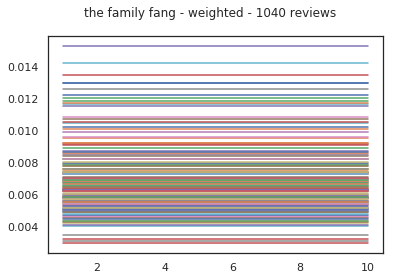

In [3]:
threshold = 25  # the threshold number of words in a review for it to be included. 
                # Any with less than 10 has already been excluded.



    
for directory, sub, files in os.walk("cleaned_posts"):
    
    # We'll use the parent directory to output files later
    parent = directory.replace("cleaned_posts","")
    
    for file in files: #iterating over the book files
        if file == "10149142-the-family-fang.json": #not in finished_books and file != ".DS_Store":
            print(directory, file)
            with open(directory+"/"+file,"r",encoding="utf8") as f:
                
                title = " ".join(file.replace(".json","").split("-")[1:]) # the title of the book
                
                df = pd.DataFrame(pd.read_json(f))
                df = df.T #I guess I saved the dataframe in the wrong orientation, so we flip it here
                
                df.sort_values(["delta"],inplace=True) # sort from earliest to latest

                # now we look at subset of the data. There is also something strange with what 
                # Seaborn wants as an index for the data and this sort helps fix that
                temp_sub_frame = df.loc[df["word_count"]>threshold]
                
                # data selection in Pandas returns a Series and for some reason Seaborn wants a list here
                sub_frame = pd.DataFrame({"delta":list(temp_sub_frame["delta"]),
                                          "word_count":list(temp_sub_frame["word_count"]),
                                          "text":list(temp_sub_frame["doc"]),
                                          "name":list(temp_sub_frame["name"])})
                
                count_reviews = len(sub_frame)
                
                if not os.path.isfile(parent+"descriptive_plots/{}_{}_joint.png".format(title,threshold)):
                    # plotting the data
                    min_x = min(sub_frame["delta"])*1.25
                    max_x = max(sub_frame["delta"])*1.25
                    g = sns.jointplot(x="delta",
                                      y="word_count",
                                      data=sub_frame,
                                      xlim=[min_x,max_x],
                                      kind="reg")
                    g = g.plot(sns.regplot, sns.distplot)
                    g.fig.suptitle(title)
                    max_y = max(sub_frame["word_count"])
                    g.fig.text(.65,.65, "{} reviews".format(count_reviews))
                    
                    g.savefig("descriptive_plots/{}_{}_joint.png".format(title,threshold),dpi=300) 
                    g.fig.clear()
                
                # Now we run topSBM
                
                model = sbmtm()
                print("creating model for {}".format(title))
                model.make_graph(list(sub_frame["text"]),list(sub_frame.index))
                model.fit(min_blocks=3)
                
                """
                We save the model object because we've done the inference step now.
                Because the stochastic realizations of the inference aren't the same, I want to save 
                any multiple states. The following while loop figures out the count of instances so 
                that we can save this instance under the right, new name.
                """
                instance = 1
                while os.path.isfile("model_inference_states/{}-{}-{}.pkl".format(title,threshold,instance)):
                      instance +=1
                
                with open("model_inference_states/{}-{}-{}.pkl".format(title, threshold, instance),"wb") as outfile:
                      outfile.write(pickle.dumps(model))
                      
                
                # here is the standard plot (documents are plotted based on their group membership)
                pos,t,tpos = model.state.draw(layout="bipartite",
                                              output_size=(1000, 1000),
                                              output="graphs/{}_{}_{}_{}.png".format(title,count_reviews, threshold, instance),
                                              hshortcuts=1,
                                              hide=0)
                
                """
                Now we're going to take the position arguments from that plot and replot the documents based 
                on when they appeared, not on community membership. The documents are already properly ordered
                in the dataframe, so we just need to iterate over the indices and add the proper increment to
                the y location.
                """
                arr = pos.get_2d_array(range(5)) # 2d array (x,y) of node positions

                increment = 1/len(model.documents) # the spacing increment
                y_val = .5 # the plot y-range is [-.5,.5] and we start at the top

                for i in range(len(model.documents)):
                      arr[1][i] = y_val
                      y_val -= increment
                      
                pos.set_2d_array(arr)

                model.state.draw(layout=pos,
                                 output_size=(1000, 1000),
                                 output="graphs/{}_{}_{}_{}_time.png".format(title, count_reviews, threshold,instance),
                                 hshortcuts=1,
                                 hide=0)
                      
                """
                Now we want to look at the change in the relative frequency of topics over time.
                We bin the documents an then try three ways of calculating frequency; binary (does the document
                have any weight on the topic? [y/n], sum of weightings across documents, sum of weighting across
                documents weighted by the document length.
                """ 
                
                num_bins = 10 #2
                count_docs = len(sub_frame)
                
                # to the best of my knowledge there is no np.linspace() with discrete spacing so a custom fnct.
                bin_counts = calc_bin_sizes(count_docs, num_bins)
                
                # calculate the relative frequencies with type of weighting equal to binary, summed, or weighted
                
                series = calc_topic_fractions(model, sub_frame, bin_counts, weight_type="binary")
                for line in series:
                    g = sns.lineplot(x=range(1,num_bins+1),y=line)
                fig = g.get_figure()
                fig.suptitle("{} - binary - {} reviews".format(title,count_reviews))
                fig.savefig("frequency_plots/{}_{}_{}_binary.png".format(title, threshold, instance))
                fig.clear()
                
                
                series = calc_topic_fractions(model, sub_frame, bin_counts, weight_type="summed")
                for line in series:
                    g = sns.lineplot(x=range(1,num_bins+1),y=line)
                fig = g.get_figure()
                fig.suptitle("{} - summed - {} reviews".format(title,count_reviews))
                fig.savefig("frequency_plots/{}_{}_{}_summed.png".format(title, threshold, instance))
                fig.clear()
                
                
                series = calc_topic_fractions(model, sub_frame, bin_counts, weight_type="weighted")
                for line in series:
                    g = sns.lineplot(x=range(1,num_bins+1),y=line)
                fig = g.get_figure()
                fig.suptitle("{} - weighted - {} reviews".format(title,count_reviews))
                fig.savefig("frequency_plots/{}_{}_{}_weighted.png".format(title, threshold, instance))

                finished_books.append(file)
            